In [1]:
%matplotlib inline

In [2]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



# phase 1: create lobe mask

In [3]:
LobesLabelMapVolume='/Shared/sinapse/CACHE/20160502_AliHCP_BAW_base_Results/BrainWeb_DATA/nii/ai_msles2_1mm/JointFusion/JointFusion_HDAtlas20_2015_lobe_label.nii.gz'

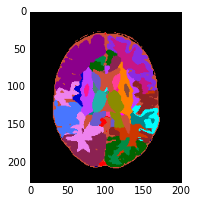

In [4]:
lobeLabels = sitk.ReadImage(LobesLabelMapVolume)
myshow(sitk.LabelToRGB(lobeLabels))

In [5]:
## define lobe labels
# ctx_lh + ctx_rh + wm_lh + wm_rh
frontal = ((lobeLabels == 9007) + (lobeLabels == 9507) + (lobeLabels == 9707) + (lobeLabels == 9807))
parietal = ((lobeLabels == 9008) + (lobeLabels == 9508) + (lobeLabels == 9708) + (lobeLabels == 9808))
occipital = ((lobeLabels == 9006) + (lobeLabels == 9506) + (lobeLabels == 9706) + (lobeLabels == 9806))
temporal = ((lobeLabels == 9003) + (lobeLabels == 9503) + (lobeLabels == 9703) + (lobeLabels == 9803))

In [6]:
# wholemask = frontal+parietal+occipital+temporal
# statFilter = sitk.StatisticsImageFilter()
# statFilter.Execute(wholemask)
# wholemask_max = statFilter.GetMaximum()
# print(wholemask_max)
# myshow(sitk.LabelToRGB(wholeMask))

(200, 226, 194)
(-100.5, -99.5, -82.5)
(1.0, 1.0, 1.0)


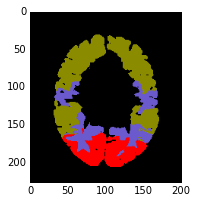

In [7]:
lobemask = ((frontal*10) + (parietal*20) + (occipital*30) + (temporal*40))
myshow(sitk.LabelToRGB(lobemask))
print(lobemask.GetSize())
print(lobemask.GetOrigin())
print(lobemask.GetSpacing())

(181, 217, 181)
(90.0, 126.0, -72.0)
(1.0, 1.0, 1.0)


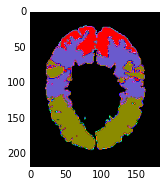

In [8]:
refImage='/Shared/pinc/sharedopt/ReferenceData/brainweb/nii/anatomicalModelOfNormalBrain/phantom_1.0mm_normal_gry.nii'
ref=sitk.ReadImage(refImage)

res=sitk.ResampleImageFilter()
res.SetReferenceImage(ref)
lobemask = res.Execute(lobemask)

myshow(sitk.LabelToRGB(lobemask))
print(lobemask.GetSize())
print(lobemask.GetOrigin())
print(lobemask.GetSpacing())

In [9]:
alllobesmaskFilename ='/Shared/johnsonhj/HDNI/20151105_BABC_on_BrainWeb_data/ai_msles2/EVALUATIONS_SEG_3mm_20170307_4lobes/all_lobes_mask.nii.gz'
sitk.WriteImage(lobemask, alllobesmaskFilename)

Now go to following directory to create stats csv file:
# /Shared/johnsonhj/HDNI/20151105_BABC_on_BrainWeb_data/ai_msles2/
# EVALUATIONS_SEG_3mm_20170307_4lobes

# phase 2: plots

In [10]:
import numpy as np
import pandas as pd
from ggplot import *

In [11]:
#----------------------------------------------------------
csv_fn='/Shared/johnsonhj/HDNI/20151105_BABC_on_BrainWeb_data/ai_msles2/EVALUATIONS_SEG_3mm_20170307_4lobes/statistics_w10.csv'
#----------------------------------------------------------

DataFrame = pd.read_csv(csv_fn)

/IPLlinux/raid0/homes/aghayoor/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


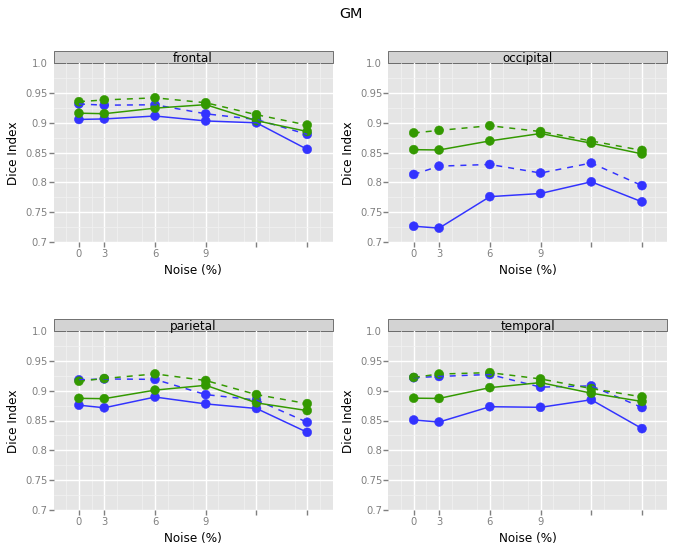

<ggplot: (295538717)>


In [12]:
df0 = DataFrame.loc[(DataFrame.roi == 'GM') & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 0) & # if multimodality + resolution
                    (DataFrame.useKnn == True) # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    #(DataFrame.lobe == 'frontal')
                    ]

p0 = ggplot(aes('noise', 'dice', linetype='usePurePlugs', color='t2resolution'), data=df0 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(0.7, 1.00) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y='Dice Index', title='GM') \
+ facet_wrap("lobe")
print(p0)

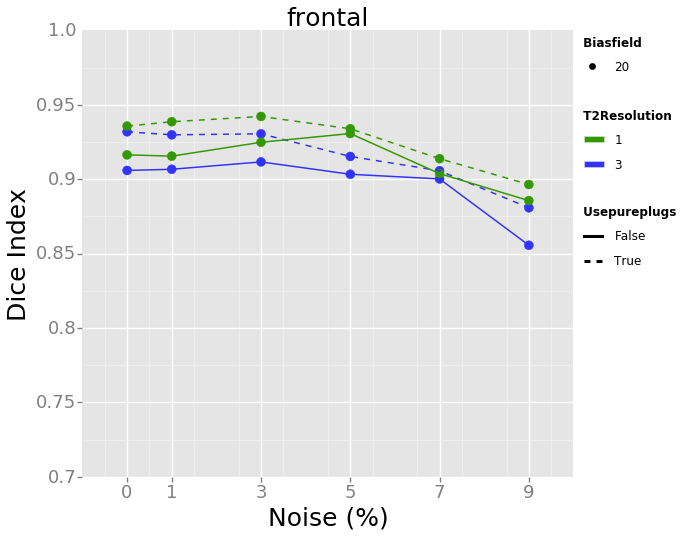

<ggplot: (296947557)>


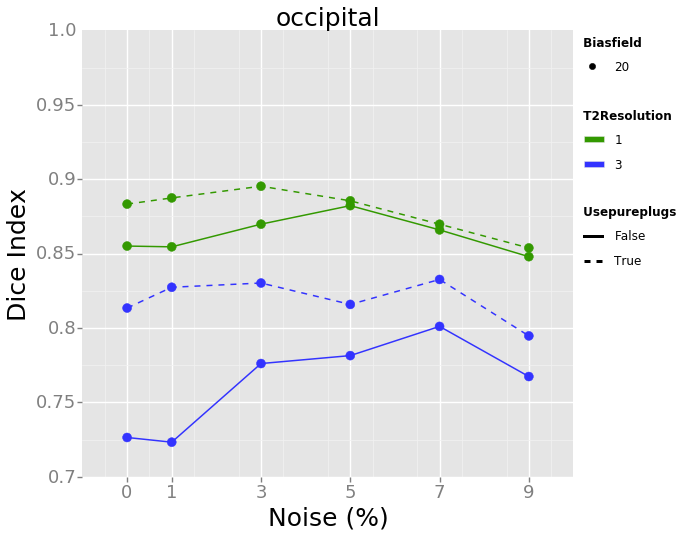

<ggplot: (297052209)>


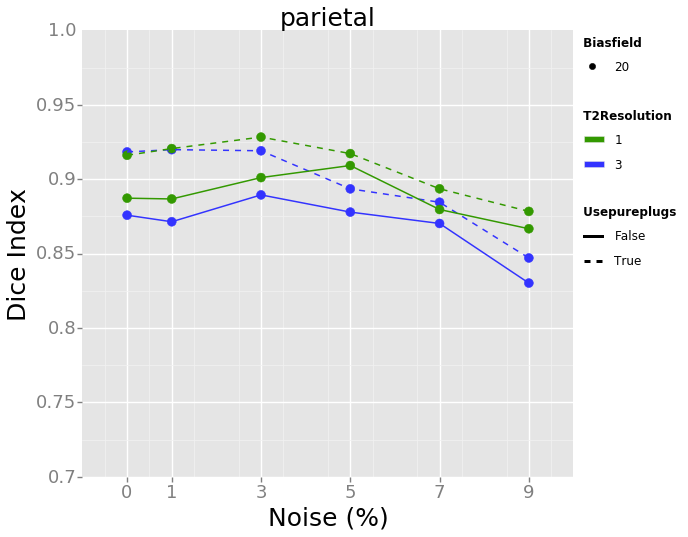

<ggplot: (296813041)>


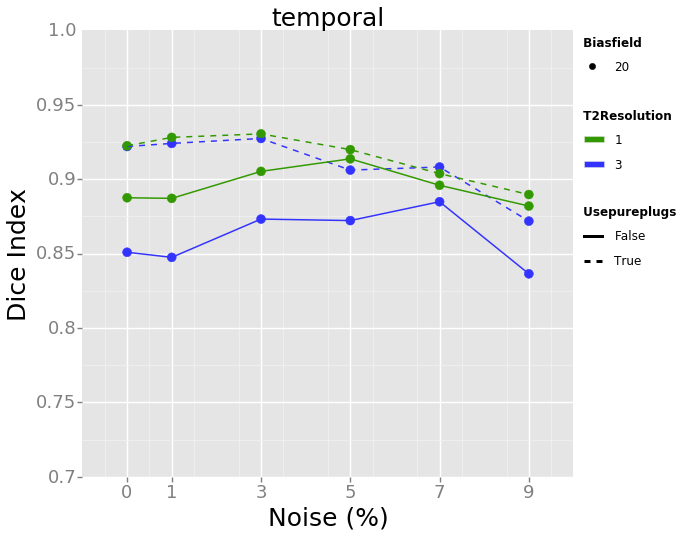

<ggplot: (296818401)>


In [13]:
metric='dice';label='Dice Index'
ylim1=0.7;ylim2=1.00
roi='GM'
#####

lobe='frontal'
df1 = DataFrame.loc[(DataFrame.roi == roi) & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 1) & # if multimodality + resolution
                    (DataFrame.useKnn == True) & # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    (DataFrame.lobe == lobe) 
                   ]

p1 = ggplot(aes('noise', metric, color='t2resolution', linetype='usePurePlugs', shape='biasField'), data=df1 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(ylim1, ylim2) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y=label, title=lobe) \
+ theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
print(p1)

#---------------------
lobe='occipital'
df1 = DataFrame.loc[(DataFrame.roi == roi) & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 1) & # if multimodality + resolution
                    (DataFrame.useKnn == True) & # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    (DataFrame.lobe == lobe) 
                   ]

p1 = ggplot(aes('noise', metric, color='t2resolution', linetype='usePurePlugs', shape='biasField'), data=df1 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(ylim1, ylim2) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y=label, title=lobe) \
+ theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
print(p1)

#---------------------
lobe='parietal'
df1 = DataFrame.loc[(DataFrame.roi == roi) & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 1) & # if multimodality + resolution
                    (DataFrame.useKnn == True) & # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    (DataFrame.lobe == lobe) 
                   ]

p1 = ggplot(aes('noise', metric, color='t2resolution', linetype='usePurePlugs', shape='biasField'), data=df1 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(ylim1, ylim2) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y=label, title=lobe) \
+ theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
print(p1)

#---------------------
lobe='temporal'
df1 = DataFrame.loc[(DataFrame.roi == roi) & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 1) & # if multimodality + resolution
                    (DataFrame.useKnn == True) & # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    (DataFrame.lobe == lobe) 
                   ]

p1 = ggplot(aes('noise', metric, color='t2resolution', linetype='usePurePlugs', shape='biasField'), data=df1 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(ylim1, ylim2) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y=label, title=lobe) \
+ theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
print(p1)

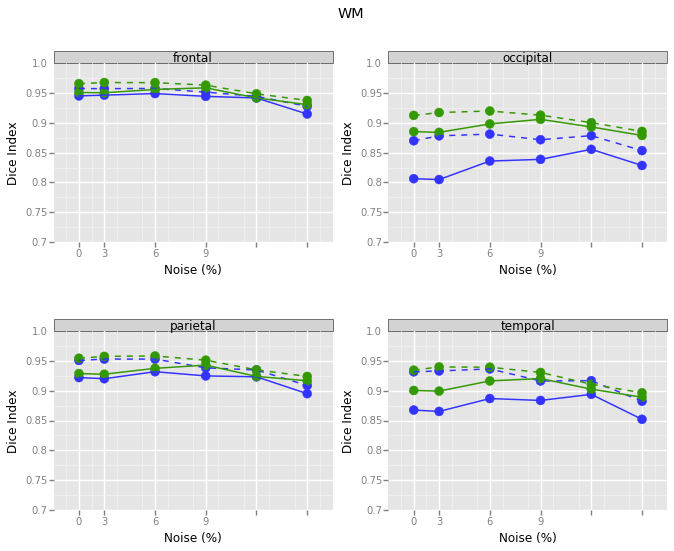

<ggplot: (296947701)>


In [14]:
df0 = DataFrame.loc[(DataFrame.roi == 'WM') & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 0) & # if multimodality + resolution
                    (DataFrame.useKnn == True) # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    #(DataFrame.lobe == 'frontal')
                    ]

p0 = ggplot(aes('noise', 'dice', linetype='usePurePlugs', color='t2resolution'), data=df0 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(0.7, 1.00) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y='Dice Index', title='WM') \
+ facet_wrap("lobe")
print(p0)

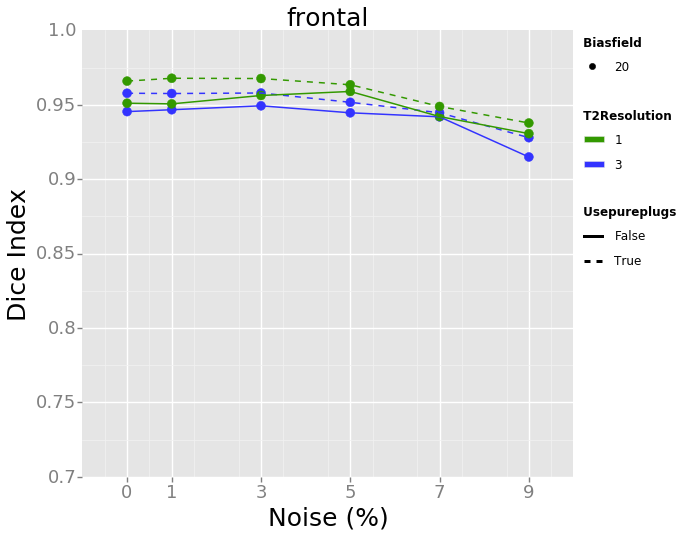

<ggplot: (300042933)>


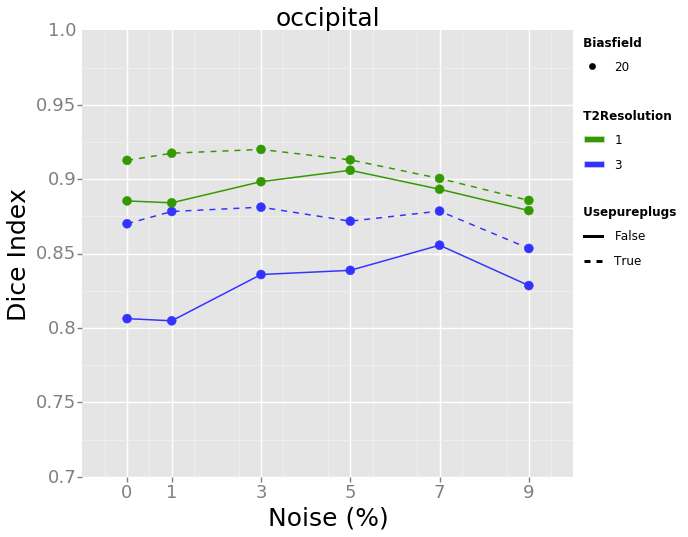

<ggplot: (300047357)>


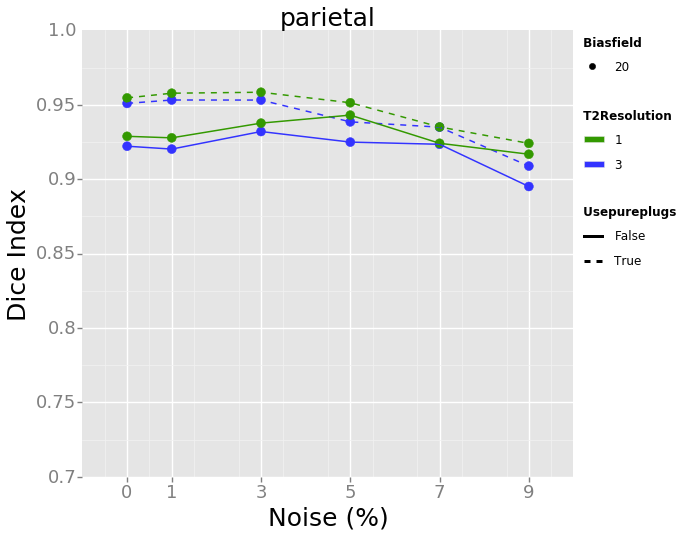

<ggplot: (300042985)>


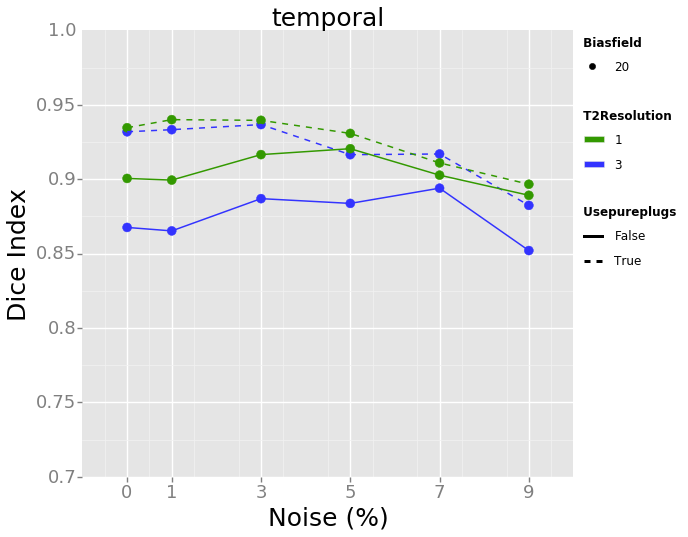

<ggplot: (296181485)>


In [15]:
metric='dice';label='Dice Index'
ylim1=0.7;ylim2=1.00
roi='WM'
#####

lobe='frontal'
df1 = DataFrame.loc[(DataFrame.roi == roi) & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 1) & # if multimodality + resolution
                    (DataFrame.useKnn == True) & # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    (DataFrame.lobe == lobe) 
                   ]

p1 = ggplot(aes('noise', metric, color='t2resolution', linetype='usePurePlugs', shape='biasField'), data=df1 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(ylim1, ylim2) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y=label, title=lobe) \
+ theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
print(p1)

#---------------------
lobe='occipital'
df1 = DataFrame.loc[(DataFrame.roi == roi) & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 1) & # if multimodality + resolution
                    (DataFrame.useKnn == True) & # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    (DataFrame.lobe == lobe) 
                   ]

p1 = ggplot(aes('noise', metric, color='t2resolution', linetype='usePurePlugs', shape='biasField'), data=df1 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(ylim1, ylim2) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y=label, title=lobe) \
+ theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
print(p1)

#---------------------
lobe='parietal'
df1 = DataFrame.loc[(DataFrame.roi == roi) & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 1) & # if multimodality + resolution
                    (DataFrame.useKnn == True) & # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    (DataFrame.lobe == lobe) 
                   ]

p1 = ggplot(aes('noise', metric, color='t2resolution', linetype='usePurePlugs', shape='biasField'), data=df1 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(ylim1, ylim2) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y=label, title=lobe) \
+ theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
print(p1)

#---------------------
lobe='temporal'
df1 = DataFrame.loc[(DataFrame.roi == roi) & # tissue region (GM or WM or CSF)
                    (DataFrame.biasField == 20) & # biasField (0 or 20 or 40)
                    (DataFrame.usePhysicalSpace == True) & # run in physical or voxel space (old or new BABC)
                    #(DataFrame.t2resolution == 1) & # if multimodality + resolution
                    (DataFrame.useKnn == True) & # use knn or not
                    #(DataFrame.usePurePlugs == False) # use pure plugs or not
                    (DataFrame.lobe == lobe) 
                   ]

p1 = ggplot(aes('noise', metric, color='t2resolution', linetype='usePurePlugs', shape='biasField'), data=df1 ) \
+ geom_point(alpha=1,size=80,) \
+ xlim(-1, 10) \
+ scale_x_continuous(breaks=(0,1,3,5,7,9)) \
+ ylim(ylim1, ylim2) \
+ geom_line(size=1.5) \
+ scale_color_manual(values=('#339900','#3333FF')) \
+ labs(x='Noise (%)', y=label, title=lobe) \
+ theme(axis_title=element_text(size=25),axis_text=element_text(size=18),title=element_text(size=25))
print(p1)